In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.version import full_version
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [4]:
img_path = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/srp_GX010027_preprocessed-oio-0.png"

In [5]:
# Load the image
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# image = image[image.shape[0]//4:, :]
image = np.hstack((image,) * 10)
# Define the width of the stripe
stripe_width = 100
shift = 10
movements = []

for i in range(0, image.shape[1]-stripe_width-shift, shift):
    # Extract vertical stripes
    left_stripe = image[:, i:stripe_width+i]
    right_stripe = image[:, i+shift:stripe_width+i+shift]
    
    # Sum pixel intensities along the x-axis
    left_sum = np.sum(left_stripe, axis=1)
    right_sum = np.sum(right_stripe, axis=1)
    
    left_sum = gaussian_filter1d(left_sum, sigma=23)
    right_sum = gaussian_filter1d(right_sum, sigma=23)
    
    distance = 150
    # Detect peaks
    peaks_left, _ = find_peaks(left_sum, distance=distance)
    peaks_right, _ = find_peaks(right_sum, distance=distance)
    
    try:
        if peaks_left.shape[0] > peaks_right.shape[0]:
            movement1 = np.mean(peaks_left[1:] - peaks_right)
            movement2 = np.mean(peaks_left[:-1] - peaks_right)
            if abs(movement1) > abs(movement2):
                movement = movement2
            else:
                movement = movement1
            
        elif peaks_left.shape[0] < peaks_right.shape[0]:
            movement1 = np.mean(peaks_left - peaks_right[:-1])
            movement2 = np.mean(peaks_left - peaks_right[1:])
            if abs(movement1) > abs(movement2):
                movement = movement2
            else:
                movement = movement1
        else: 
            movement = np.mean(peaks_left - peaks_right)
            
        if abs(movement) > 5 or movement is None:
            movement = movements[-1]
        movements.append(movement)
    except:
        movements.append(movements[-1])
        # # Plot the results
        # plt.figure(figsize=(10, 5))
        # plt.plot(left_sum, label="Left Stripe")
        # plt.plot(right_sum, label="Right Stripe")
        # plt.title("Summed Pixel Intensities")
        # plt.xlabel("Vertical Position (pixels)")
        # plt.ylabel("Summed Intensity")
        # plt.legend()
        # plt.show()
        #
        # # Display detected peaks
        # print("Peaks in left stripe:", peaks_left)
        # print("Peaks in right stripe:", peaks_right)

In [6]:
len(movements), image.shape[1], max(movements), min(movements)

(7814, 78250, np.float64(2.6), np.float64(-3.8))

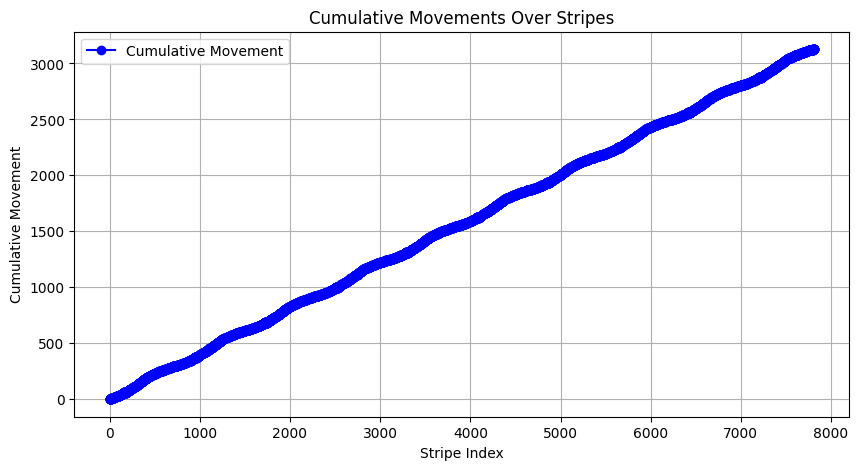

In [7]:
cumulative_movements = np.cumsum(movements)
    
# Plot cumulative movements
plt.figure(figsize=(10, 5))
plt.plot(cumulative_movements, marker='o', linestyle='-', color='blue', label="Cumulative Movement")
plt.title("Cumulative Movements Over Stripes")
plt.xlabel("Stripe Index")
plt.ylabel("Cumulative Movement")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Generate x-values corresponding to movement indices
x = np.arange(len(movements))

# Linear regression to remove rotation
coefficients = np.polyfit(x, cumulative_movements, deg=1)
linear_trend = np.polyval(coefficients[-2:], x)

In [9]:
coefficients, np.arctan(coefficients[-2])

(array([0.40035913, 8.16254158]), np.float64(0.3808159335875352))

In [10]:
detrended_movements = cumulative_movements - linear_trend

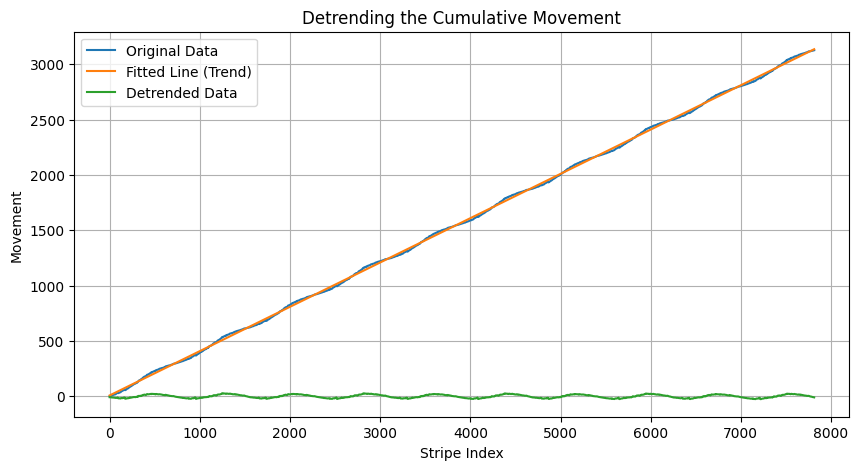

In [11]:
# Plot to visualize detrending
plt.figure(figsize=(10, 5))
plt.plot(x, cumulative_movements, label="Original Data")
plt.plot(x, linear_trend, label="Fitted Line (Trend)")
plt.plot(x, detrended_movements, label="Detrended Data")
plt.legend()
plt.xlabel("Stripe Index")
plt.ylabel("Movement")
plt.title("Detrending the Cumulative Movement")
plt.grid(True)
plt.show()

In [12]:
def sinusoid(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

def rotated_sinusoid(x, A, B, C, D, theta):
    y = A * np.sin(B * x + C) + D
    # Rotate the sinusoid using the angle theta
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    return y_rot

In [13]:
slope = coefficients[-2]
theta_initial = np.arctan(slope)

In [14]:
theta_initial

np.float64(0.3808159335875352)

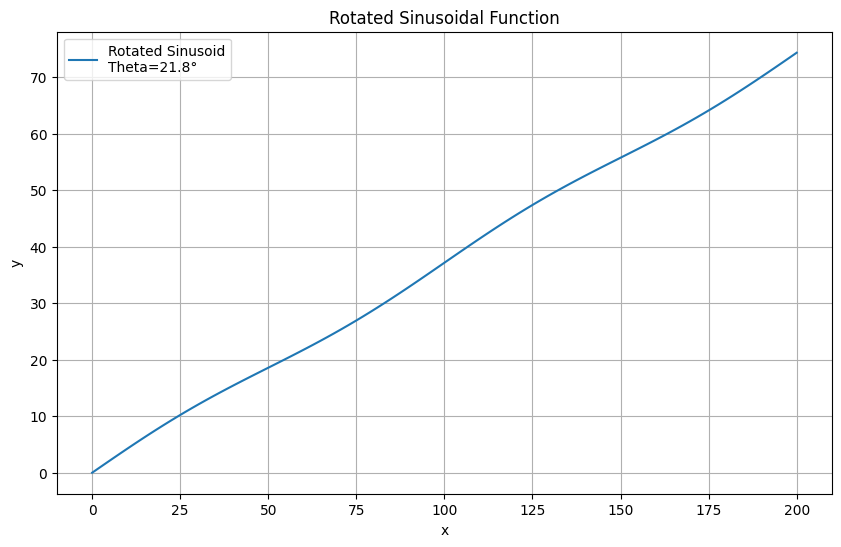

In [15]:
# Test parameters
A = 1       # Amplitude
B = 2 * np.pi / 100  # Frequency (a full wave in 100 points)
C = 0       # Phase shift
D = 0       # Vertical shift
theta = theta_initial  # Rotation angle (30 degrees)

# Create x values
x = np.linspace(0, 200, 100)

# Generate the data based on the parameters
y = rotated_sinusoid(x, A, B, C, D, theta)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Rotated Sinusoid\nTheta={np.degrees(theta):.1f}°')
plt.title('Rotated Sinusoidal Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
movements = detrended_movements

In [17]:
np.max(movements), np.min(movements), (np.max(movements) - np.min(movements)) /2, max(np.max(movements), -np.min(movements))

(np.float64(26.58854592733286),
 np.float64(-26.055460119370764),
 np.float64(26.32200302335181),
 np.float64(26.58854592733286))

Amplitude: 20.291886057415525, Frequency: 0.008040933333989744, Phase: -2.653240878563649, Vertical Shift: 1.7146522178817467, Theta: -0.0004389228465770764


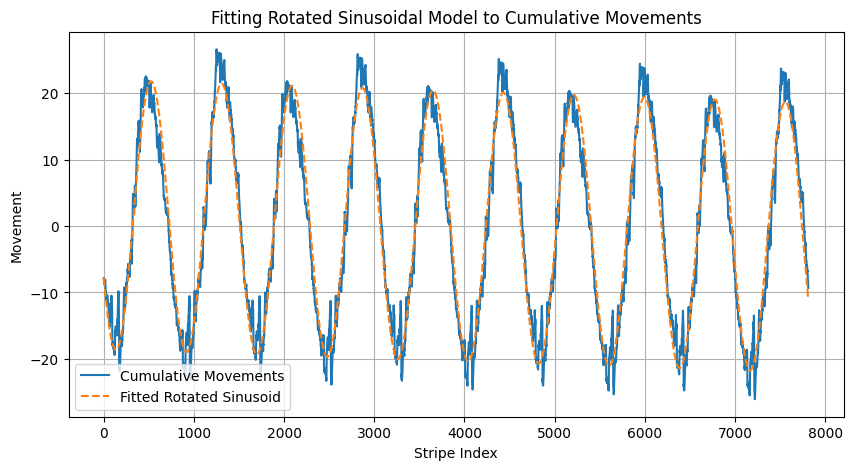

In [22]:
# Example: X and Cumulative Movements (you can replace this with your actual data)
x = np.arange(len(movements))

max_m = np.max(movements)
min_m = np.min(movements)
freq = 2*10*np.pi / len(movements)

custom_rotated_sinusoid = lambda x, A, C, D, theta: rotated_sinusoid(x, A, freq, C, D, theta)

# Initial guess for parameters: [Amplitude, Frequency, Phase, Vertical shift, Rotation]
initial_guesses = [(max_m - min_m)/2, 0, 0, 0]

lower_bounds = [0, -np.pi, -100, -0.1]  # Set lower bounds
upper_bounds = [max(max_m, -min_m), np.pi, +100, 0.1]  # Set upper bounds

# Fit the model
params, _ = curve_fit(custom_rotated_sinusoid, x, movements, p0=initial_guesses, bounds=(lower_bounds, upper_bounds), method='trf', maxfev=5000)

# Extract fitted parameters
A, C, D, theta = params
print(f"Amplitude: {A}, Frequency: {freq}, Phase: {C}, Vertical Shift: {D}, Theta: {theta}")

# Generate fitted rotated sinusoid
fitted_rotated_sinusoid = rotated_sinusoid(x, A, freq, C, D, theta)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, movements, label="Cumulative Movements")
plt.plot(x, fitted_rotated_sinusoid, label="Fitted Rotated Sinusoid", linestyle="--")
plt.legend()
plt.xlabel("Stripe Index")
plt.ylabel("Movement")
plt.title("Fitting Rotated Sinusoidal Model to Cumulative Movements")
plt.grid(True)
plt.show()

In [25]:
paramses = np.array([
  [2.00336645e+01, 8.04093333e-03, -2.66016276e+00, 1.69895699e+00, -4.34905127e-04],
  [2.27618893e+01, 8.04093333e-03, -2.19498536e+00, 1.27725848e+00, -3.26957233e-04],
  [1.80510301e+01, 8.04093333e-03, -1.60502242e+00, 6.59030383e-02, -1.68700981e-05],
  [2.44410522e+01, 8.04093333e-03, -1.56720736e+00, 1.00697356e-03, -2.57768734e-07],
  [1.97206081e+01, 8.04093333e-03, -9.74036047e-01, -1.05187899e+00, 2.69263794e-04],
  [3.10071048e+01, 8.04093333e-03, -6.72497699e-01, -2.30854140e+00, 5.90948711e-04]
])


In [24]:
# Separate odd and even indexed rows
even_rows = paramses[0::2]  # Rows with even indices (0, 2, 4, ...)
odd_rows = paramses[1::2]   # Rows with odd indices (1, 3, 5, ...)

# Calculate mean along axis=0
mean_even = np.mean(even_rows, axis=0)
mean_odd = np.mean(odd_rows, axis=0)

print("Mean of even rows:", mean_even)
print("Mean of odd rows:", mean_odd)

Mean of even rows: [ 1.92684342e+01  8.04093333e-03 -1.74640708e+00  2.37660346e-01
 -6.08371437e-05]
Mean of odd rows: [ 2.60700154e+01  8.04093333e-03 -1.47823014e+00 -3.43425315e-01
  8.79112364e-05]


In [197]:
A, B, C, D, theta = np.median(paramses, axis=0)

In [198]:
A, B, C, D, theta

(np.float64(22.982092700000003),
 np.float64(0.00856019797),
 np.float64(-1.663230885),
 np.float64(23.080506149999998),
 np.float64(0.43400665400000005))

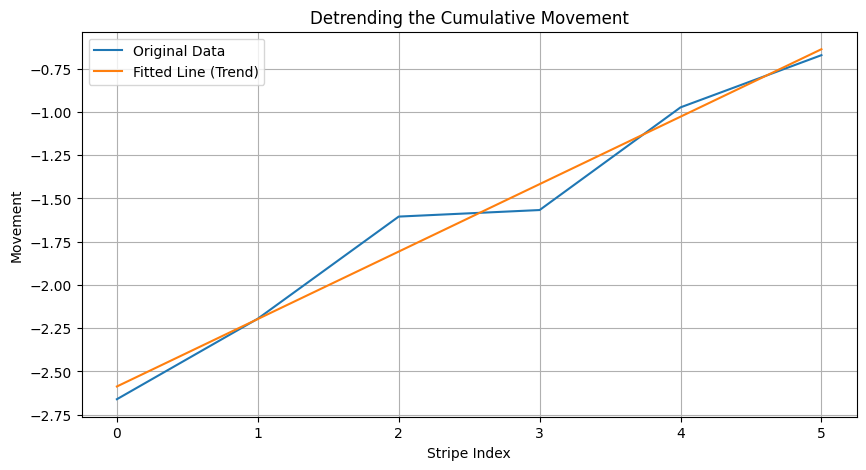

In [33]:
phases = np.array(paramses)[:, 2]
coefficients = np.polyfit(np.arange(6), phases, deg=1)
linear_trend = np.polyval(coefficients, np.arange(6))
# Plot to visualize detrending
plt.figure(figsize=(10, 5))
plt.plot(np.arange(6), phases, label="Original Data")
plt.plot(np.arange(6), linear_trend, label="Fitted Line (Trend)")
plt.legend()
plt.xlabel("Stripe Index")
plt.ylabel("Movement")
plt.title("Detrending the Cumulative Movement")
plt.grid(True)
plt.show()

In [153]:
np.roll([1,2,3], -1)

array([2, 3, 1])

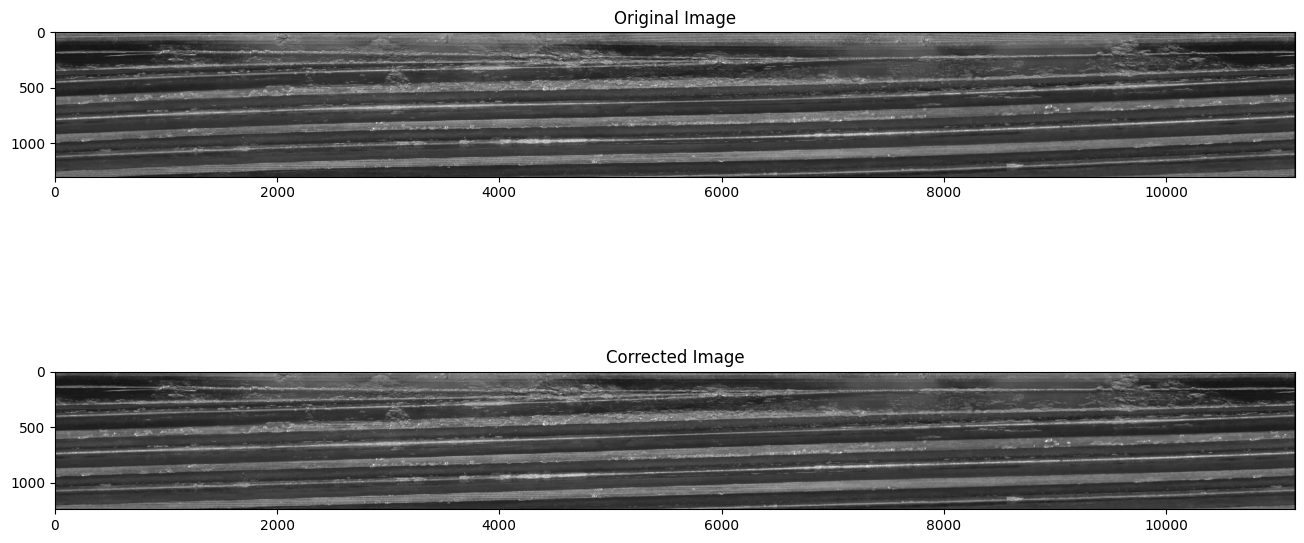

In [403]:
# Define function to remove sinusoidal distortion (column-wise)
def remove_sinusoidal_transformation(image, params):
    A, B, C, D, theta = params
    
    # Create an empty output image
    output_image = np.zeros_like(image)
    
    # Track the maximum shift
    max_shift = 0
    
    # Loop over each column
    for j in range(image.shape[1]):
        # Calculate the vertical shift for this column based on the sinusoidal function
        shift = sinusoid(j, A, B/10, C, D)
        max_shift = max(max_shift, abs(shift))  # Update maximum shift
        
        # Shift the whole column
        # Use np.roll to shift the column by the calculated value
        new_column = np.roll(image[:, j], int(shift))
        
        # Assign the shifted column back to the output image
        output_image[:, j] = new_column
    
    # Crop the image to remove the wrapped-around pixels
    if max_shift > 0:
        output_image = output_image[int(max_shift): -int(max_shift), :]
    
    return output_image

image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# Apply the removal
output_image = remove_sinusoidal_transformation(image, params)

# Display the original and corrected image
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.subplot(2, 1, 2)
plt.title("Corrected Image")
plt.imshow(output_image, cmap="gray")
plt.show()
